In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import statistics as stats

C:\Users\Chaitanya\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [73]:
start_date="2014-01-01"
end_date="2020-01-01"
goog_data=data.DataReader('GOOG', 'yahoo', start_date, end_date)

In [85]:
# Simple Moving Average

def sma(data,period):
    #SMA calculation using rolling function
    data["SMA_"+str(period)]=data["Close"].rolling(window=period).mean()

# Exponential Moving Average
    
def ema(data,periods):
    # Smoothing Constant
#     EMA=(P-EMA_old)*K+EMA_old
    K=2/(periods+1)#Change K for configuring weights of new prices
    ema=[]
    for i in range(len(data)):
        if i==0:
            ema.append(data["Close"][i])
        else:
            ema.append(K*(data["Close"][i]-ema[i-1])+ema[i-1])
    data["ema_"+str(periods)]=ema

# Rolling Moving Average

def rma(data,period):
    '''
        RMA_t=(RMA_t-1*(period-1)+current)/period
    '''
    df=pd.DataFrame(index=data.index)
    df["Close"]=data["Close"]
    arr=[0]*period
    arr.append(df["Close"].iloc[1:period+1].sum()/period)
    for i in range(period+1,len(df)):
        arr.append((arr[i-1]*(period-1)+df["Close"].iloc[i])/period)
    data["rma_"+str(period)]=arr
    

# Absolute Price Oscillator

def apo(data,fast_period,slow_period):
#     APO=EMAfast-EMAslow
    df=pd.DataFrame(index=data.index)
    df["Close"]=data["Close"]
    ema(df,fast_period)
    ema(df,slow_period)
    data["apo"]=df["ema_"+str(fast_period)]-df["ema_"+str(slow_period)]
    
#  MACD

def macd(data,fast_period,slow_period,period):
#     MACD=EMAfast-EMAslow
# MACD signal=EMAmacd
# MACDhistogram=MACD-MACDsignal
    df=pd.DataFrame(index=data.index)
    df["Close"]=data["Close"]
    apo(df,fast_period=fast_period,slow_period=slow_period)
    data["macd"]=df["apo"]
    df=pd.DataFrame(index=data.index)
    df["Close"]=data["macd"]
    ema(df,periods=period)
    data["macd_signal"]=df["ema_"+str(period)]
    data["macd_hist"]=data["macd"]-data["macd_signal"]
    
# Bollinger Band
    
def bband(data,period,fac=2):
#     BBANDmiddle=SMA(n-days)
#     BBANDupper=BBANDmiddle+(std*std_dev_factor)
#     BBANDlower=BBANDmiddle-(std*std_dev_factor) 
#     std^2=sum((Pi-SMA)^2)/n
    df=pd.DataFrame(index=data.index)
    df["Close"]=data["Close"]
    sma(df,period=period)
    data["BBAND_middle"]=df["SMA_"+str(period)]
    stddev(df,period)
    data["BBAND_upper"]=data["BBAND_middle"]+fac*df["stddev_"+str(period)]
    data["BBAND_lower"]=data["BBAND_middle"]-fac*df["stddev_"+str(period)]
    
# Relative Strength Index

def rsi(data,period):
    '''
    Absolute Gain Over Period=Price-Previous Price
    Absolute Loss Over period=Previous Price-Price
    Relative Strength(RS)=sum(abs(Gain over last n periods))/sum(abs(Loss over n periods))
    RSI=100-100/(1+RS)
    '''
    
    df=pd.DataFrame(index=data.index)
    df["Close"]=data["Close"]
    df["price_diff"]=df["Close"].diff()#Price-PreviousPrice
    df["ag"]=np.where(df["price_diff"].values>0,df["price_diff"].values,0)
    df["al"]=np.where(df["price_diff"].values<0,-df["price_diff"].values,0)
    df1=pd.DataFrame(index=data.index)
    df1["Close"]=df["ag"]
    rma(df1,period)
    df2=pd.DataFrame(index=data.index)
    df2["Close"]=df["al"]
    rma(df2,period)
    df["rs"]=np.where(df2["rma_"+str(period)]>0,df1["rma_"+str(period)]/df2["rma_"+str(period)],0)
    df["rsi"]=100-100/(1+df["rs"])
    data["rsi"]=df["rsi"]

# Standard Deviation

def stddev(data,period):
    df=pd.DataFrame(index=data.index)
    df["Close"]=data["Close"]
#     sma(df,period=period)
#     df["variance"]=(np.square(df["Close"]-df["SMA_"+str(period)])).rolling(window=period).mean()
    data["stddev_"+str(period)]=df["Close"].rolling(period).std()
    
# Mometum Indicator

def mom(data,period):
    '''
        MOM=Price_t-Price_(t-n)
    '''
    df=pd.DataFrame(index=data.index)
    df["Close"]=data["Close"]
    arr=[0]*(period-1)
    for i in range(period-1,len(data)):
        arr.append(df["Close"].iloc[i]-df["Close"].iloc[i-period+1])
    data["mom_"+str(period)]=arr
    
def plot_rolling_statistics_ts(ts,titletext,ytext,window_size=12):
    plt.figure(figsize=(16,6))
    ts.plot(color="red",label="Original",lw=0.5)
    ts.rolling(window_size).mean().plot(color='blue',label='Rolling Mean')
    ts.rolling(window_size).std().plot(color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.ylabel(ytext)
    plt.title(titletext)
    plt.tight_layout()
    plt.show(block=False)

In [75]:
time_period_SMA=20
sma(goog_data,time_period_SMA)

time_period_EMA=20
ema(goog_data,time_period_EMA)

fast_period=10
slow_period=40
apo(goog_data,fast_period,slow_period)

fast_period=10
slow_period=40
macd(goog_data,fast_period=fast_period,slow_period=slow_period,period=20)

time_period=20
bband(goog_data,period=time_period)

time_period=14
rsi(goog_data,time_period)

time_period=20
stddev(goog_data,time_period)

time_period=20
mom(goog_data,time_period)

C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in greater
C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in less


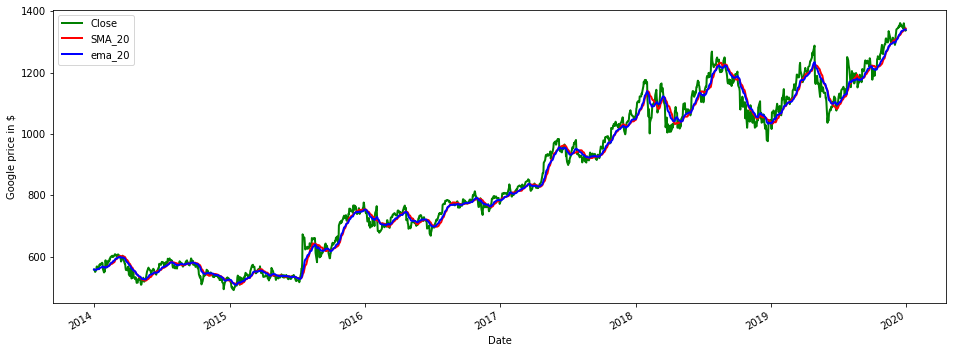

In [76]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(111,ylabel="Google price in $")
goog_data["Close"].plot(ax=ax1,color="g",lw=2,legend=True)
goog_data["SMA_"+str(time_period_SMA)].plot(ax=ax1,color="r",lw=2,legend=True)
goog_data["ema_"+str(time_period_EMA)].plot(ax=ax1,color="b",lw=2,legend=True)

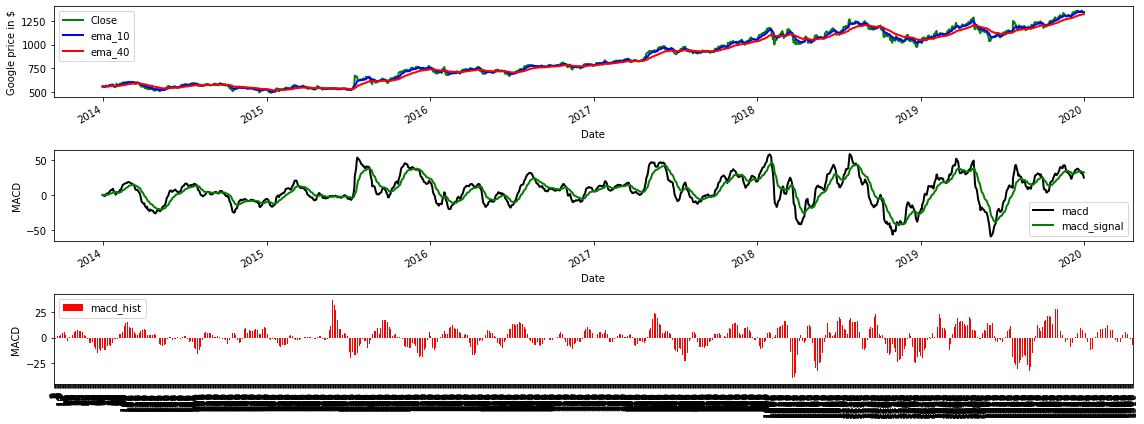

In [77]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(311, ylabel='Google price in $')
ema_fs=pd.DataFrame(index=goog_data.index)
ema_fs["Close"]=goog_data["Close"]
ema(ema_fs,fast_period)
ema(ema_fs,slow_period)
ema_fs["Close"].plot(ax=ax1, color='g', lw=2., legend=True)
ema_fs["ema_"+str(fast_period)].plot(ax=ax1, color='b', lw=2., legend=True)
ema_fs["ema_"+str(slow_period)].plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='MACD')
goog_data["macd"].plot(ax=ax2, color='black', lw=2., legend=True)
goog_data["macd_signal"].plot(ax=ax2, color='g', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='MACD')
goog_data["macd_hist"].plot(ax=ax3, color='r', kind='bar', legend=True,use_index=False)
plt.tight_layout()
plt.legend(loc=0)

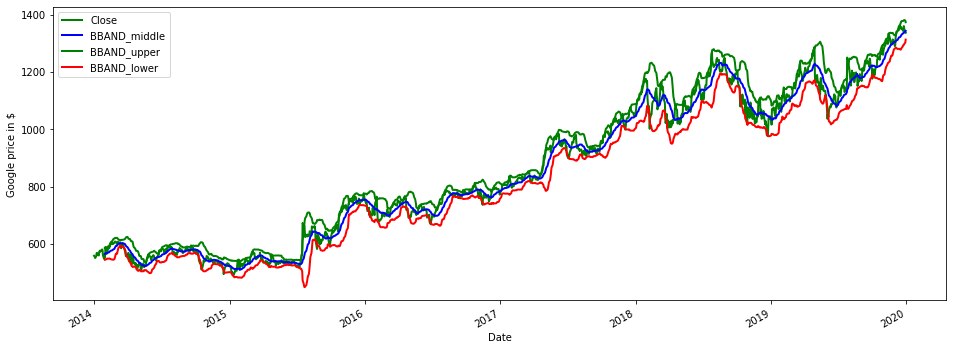

In [78]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Close"].plot(ax=ax1, color='g', lw=2., legend=True)
goog_data["BBAND_middle"].plot(ax=ax1, color='b', lw=2., legend=True)
goog_data["BBAND_upper"].plot(ax=ax1, color='g', lw=2., legend=True)
goog_data["BBAND_lower"].plot(ax=ax1, color='r', lw=2., legend=True)

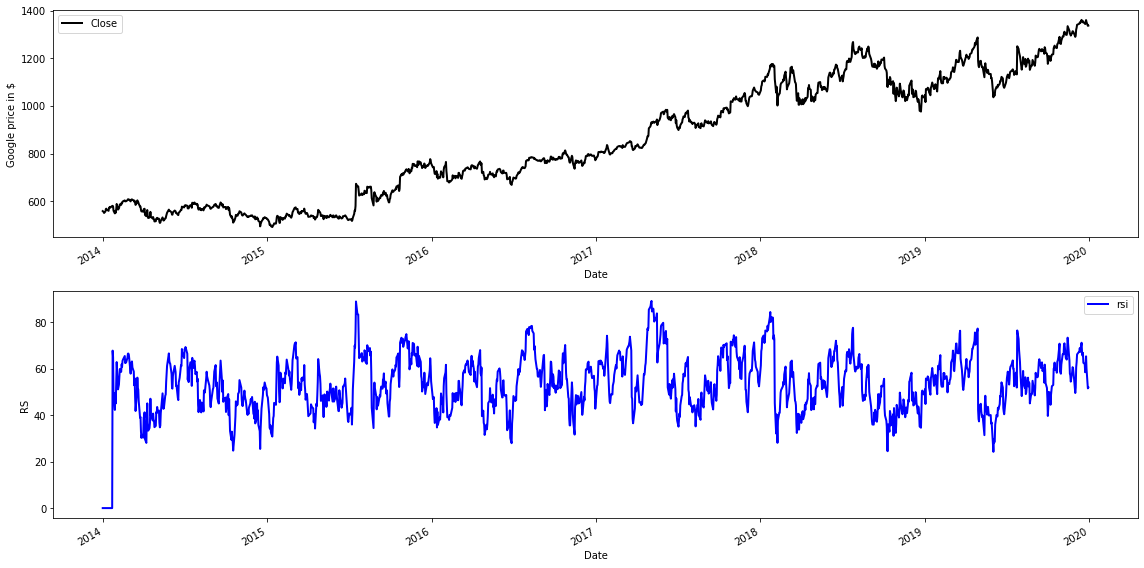

In [79]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
goog_data["Close"].plot(ax=ax1, color='black', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='RS')
goog_data["rsi"].plot(ax=ax2, color='b', lw=2., legend=True)
plt.tight_layout()

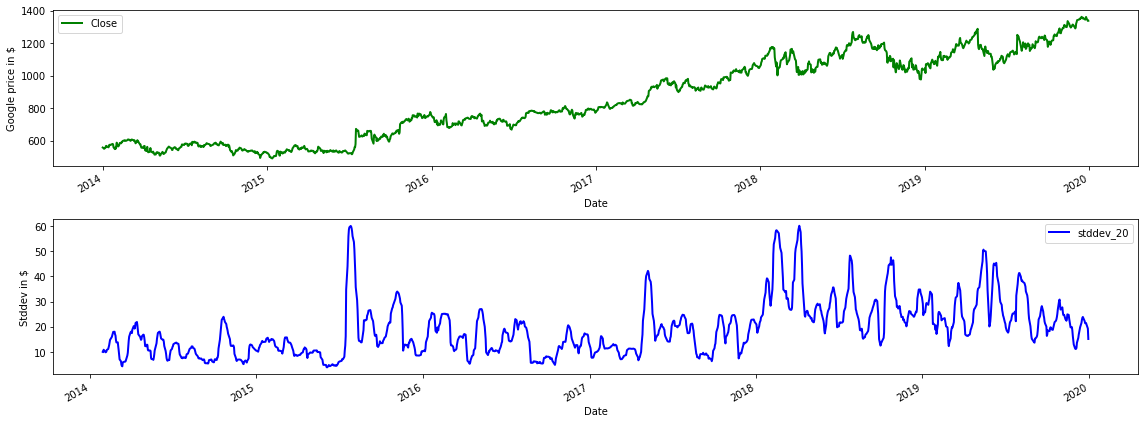

In [80]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
goog_data["Close"].plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Stddev in $')
goog_data["stddev_"+str(time_period)].plot(ax=ax2, color='b', lw=2., legend=True)
plt.tight_layout()

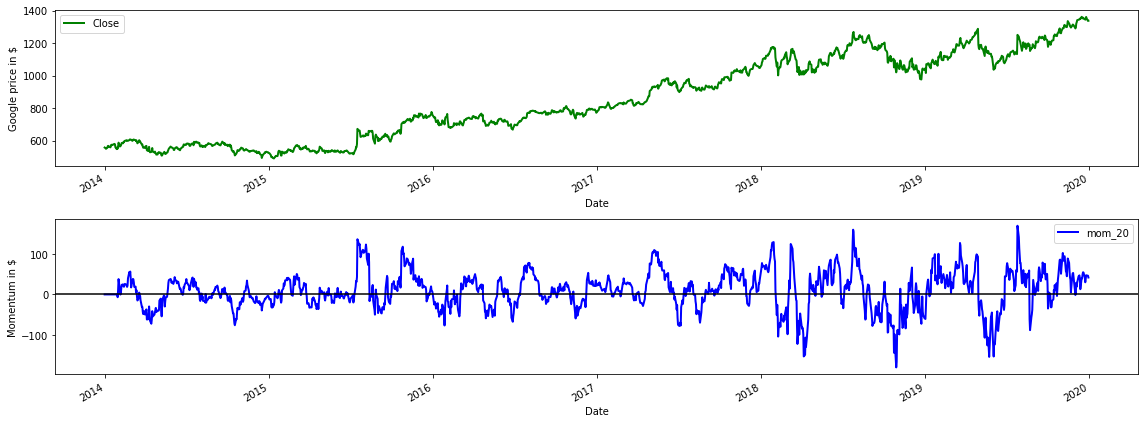

In [81]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
goog_data["Close"].plot(ax=ax1, color='g', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='Momentum in $')
goog_data["mom_"+str(time_period)].plot(ax=ax2, color='b', lw=2., legend=True)
plt.axhline(y=0,color="k")
plt.tight_layout()

In [84]:
goog_data

,High,Low,Open,Close,Volume,Adj Close,SMA_20,ema_20,apo,macd,macd_signal,macd_hist,BBAND_middle,BBAND_upper,BBAND_lower,rsi,stddev_20,mom_20
Date,,,,,,,,,,,,,,,,,,
2013-12-31,558.406982,551.064453,554.043335,558.262512,2725900.0,558.262512,NaN,558.262512,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,0.000000
2014-01-02,556.788025,552.060730,555.647278,554.481689,3656400.0,554.481689,NaN,557.902434,-0.502992,-0.502992,-0.047904,-0.455088,NaN,NaN,NaN,0.000000,NaN,0.000000
2014-01-03,556.379578,550.401978,555.418152,550.436829,3345800.0,550.436829,NaN,557.191424,-1.428114,-1.428114,-0.179353,-1.248761,NaN,NaN,NaN,0.000000,NaN,0.000000
2014-01-06,557.340942,551.154114,554.426880,556.573853,3551800.0,556.573853,NaN,557.132608,-1.318987,-1.318987,-0.287889,-1.031098,NaN,NaN,NaN,0.000000,NaN,0.000000
2014-01-07,567.717041,558.486633,560.399475,567.303589,5124300.0,567.303589,NaN,558.101272,0.205101,0.205101,-0.240938,0.446039,NaN,NaN,NaN,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,1343.560059,1335.213513,1336.844517,31.702466,31.702466,33.573661,-1.871195,1335.213513,1378.081918,1292.345109,58.411350,21.434202,30.010010
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,1360.400024,1337.556012,1339.087899,31.971248,31.971248,33.421050,-1.449802,1337.556012,1380.560012,1294.552012,65.243314,21.502000,47.410034
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,1351.890015,1339.501013,1340.307148,30.764721,30.764721,33.168066,-2.403345,1339.501013,1381.329479,1297.672547,59.889141,20.914233,46.930054


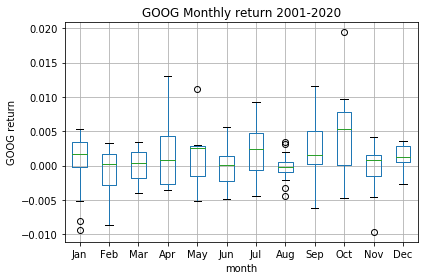

In [68]:
goog_monthly_return=goog_data["Adj Close"].pct_change().groupby([goog_data["Adj Close"].index.year,goog_data["Adj Close"].index.month]).mean()
goog_monthly_return_list=[]

for i in range(len(goog_monthly_return)):
    goog_monthly_return_list.append({'month':goog_monthly_return.index[i][1],'monthly_return':goog_monthly_return[i]})

goog_monthly_return_list=pd.DataFrame(goog_monthly_return_list,columns=('month','monthly_return'))

goog_monthly_return_list.boxplot(column="monthly_return",by="month")
ax=plt.gca()
labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(labels)
ax.set_ylabel('GOOG return')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("GOOG Monthly return 2001-2020")
plt.suptitle("")
plt.tight_layout()

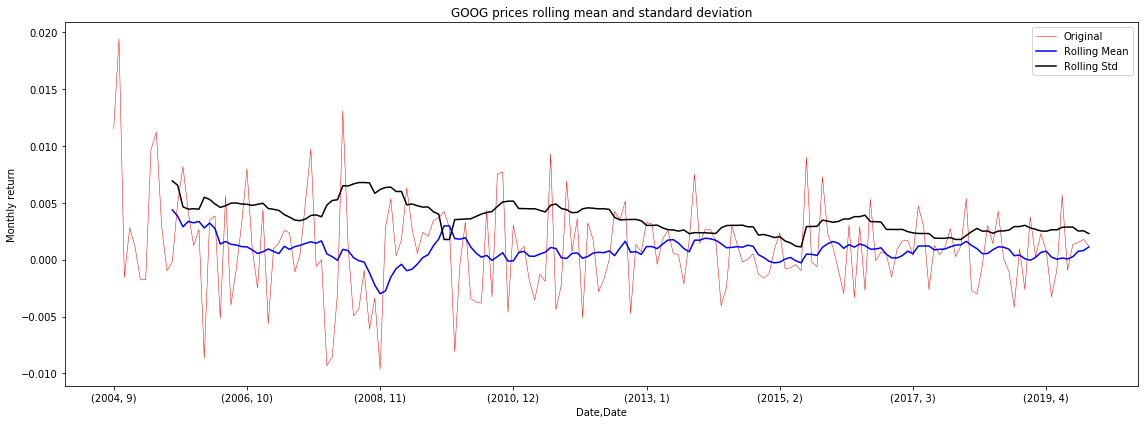

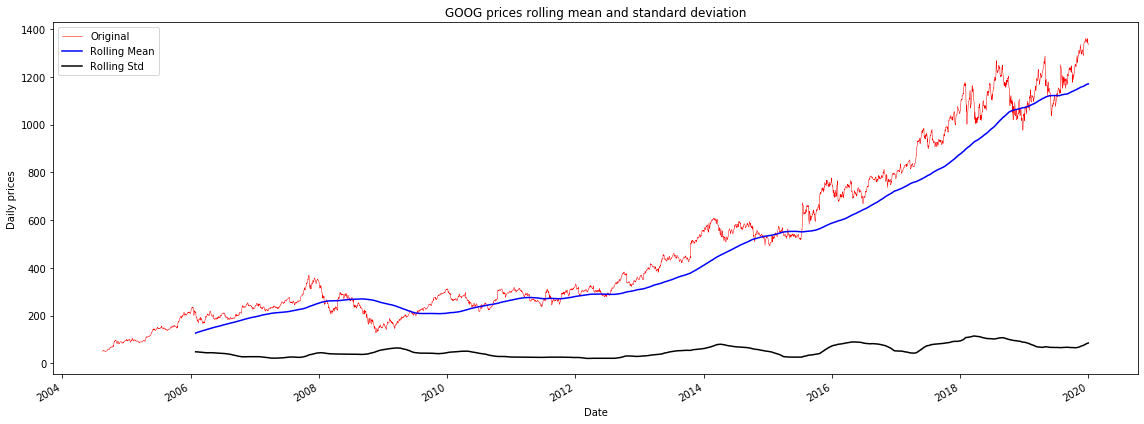

In [70]:
plot_rolling_statistics_ts(goog_monthly_return[1:],'GOOG prices rolling mean and standard deviation','Monthly return')
plot_rolling_statistics_ts(goog_data['Adj Close'],'GOOG prices rolling mean and standard deviation','Daily prices',365)